In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd

import pickle

import copy

import scipy.io as io

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar
%matplotlib inline

from skimage import measure
from skimage.filters import gaussian

from impdar import *

from autopicker_methods import *

In [2]:
#files on disk
green_image = '../images/nline5.png'
green_mat = '../data/nline5_migtk_cropped.mat'

#load in data
dat = io.loadmat(green_mat)
data = dat['data']

#original image
mini = -8.774235248565674
maxi = 9.667154026031533

### Data cropping thoughts:

Is there some way to make this automatic? For instance, Ben mentioned that we could look at the power of the bed, and then set some cutoff value. So look at the bed and say: what is the **minimum** value where this criteria is met? For flat beds, this would work well. But for not so flat beds, this could be problematic because you would not pick as many internal reflectors that dip down to follow the bed.

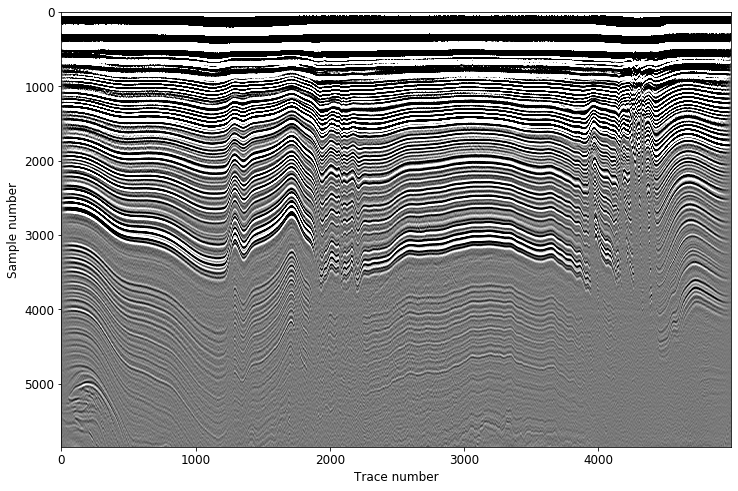

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.xlabel('Trace number', fontsize=12)
plt.ylabel('Sample number', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

### Contouring

In [3]:
#get positive and negative contours
pos = measure.find_contours(data, 3)
neg = measure.find_contours(data, -3)

In [4]:
#save contours and their lengths to lists
c_pos, c_neg, c_length_pos, c_length_neg = [], [], [], []

In [5]:
#positive contours
for contour in pos:
    c_pos.append(contour)

#negative contours
for contour in neg:
    c_neg.append(contour)

#now extract long contours
#this could be done instead of filtering?
for contour in pos:
    c_length_pos.append(len(contour))
    
for contour in neg:
    c_length_neg.append(len(contour))

In [6]:
#find the longest contour
print(np.argmax(c_length_pos))
print(c_length_pos[38])

print(np.argmax(c_length_neg))
print(c_length_neg[298])

#create an iterable list of the contours that are longer than some arbitrary value
long_contours_pos_idx = list(np.where(np.array(c_length_pos) > 250)[0])
long_contours_neg_idx = list(np.where(np.array(c_length_neg) > 250)[0])

38
44400
298
30373


In [7]:
long_contours_pos = [pos[idx] for idx in long_contours_pos_idx]
long_contours_neg = [neg[idx] for idx in long_contours_neg_idx]

In [8]:
#isolate some internal reflectors
long_contours_subset = long_contours_pos[22:100]

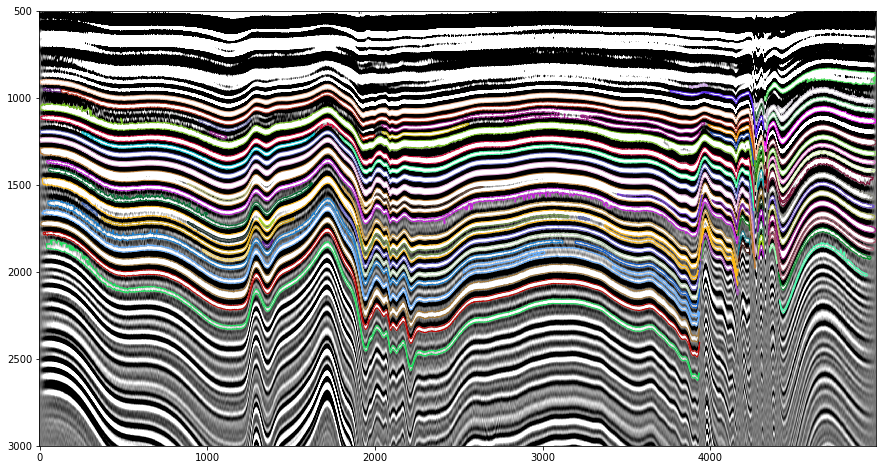

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for i, contour in enumerate(long_contours_subset):
    plt.plot(contour[:, 1], contour[:, 0], color=np.random.rand(3,), linewidth=1)
    
ax.set_ylim(3000, 500)

plt.show()

### find end points

In [10]:
z = 1
argx1 = np.argmin(long_contours_subset[z][:, 1])
argx2 = np.argmax(long_contours_subset[z][:, 1])

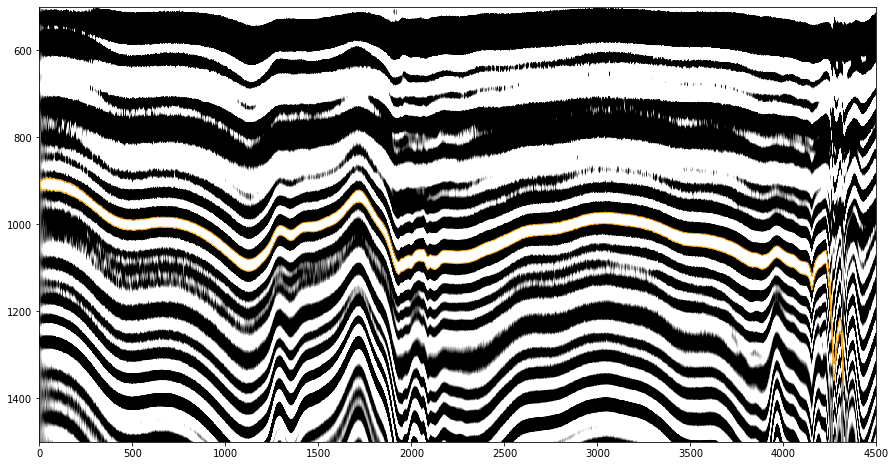

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(long_contours_subset[z][:, 1], long_contours_subset[z][:, 0], color='orange', linewidth=1)

ax.set_xlim(0, 4500)
ax.set_ylim(1500, 500)

plt.show()

In [11]:
uniquex = (list(set([int(x) for x in long_contours_subset[z][:, 1]])))

In [12]:
saved_points2 = []
delete = []

for i, x in enumerate(uniquex):
    wherex = np.where(long_contours_subset[1][:, 1]==x)[0]
    if len(wherex) == 0:
        delete.append(x)
    else:
        if len(wherex) > 2:
            saved_points2.append(wherex[1:3])
            #print(i, wherex[1:3])
        else:
            saved_points2.append(wherex)
            #print(i, wherex)
            
uniquex = [x for x in uniquex if x not in delete]
#print(len(uniquex))

### find y values, ridge points

In [13]:
ridge_points2 = []

In [14]:
for i, point in enumerate(saved_points2):
    if(len(point == 2)):
        idx3 = point[0]
        idx4 = point[1]
    elif(len(point > 2)):
        idx3 = point[1]
        idx4 = point[2]
    else:
        raise ValueException("You need to have at least two matching y-values.")
    
    x = uniquex[i]
    
    y1 = int(long_contours_subset[1][idx3, 0])
    y2 = int(long_contours_subset[1][idx4, 0])
    
    if len(data[y2:y1, x]) == 0:
        #print(i, x, np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
        ridge_points2.append(np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
    else:
        #print(i, x, np.where(data[:, x] == np.max(data[y2:y1, x]))[0])
        ridge_points2.append(np.where(data[:, x] == np.max(data[y2:y1, x]))[0])

#### find troughs

In [15]:
top, bottom = find_troughs_single(uniquex, ridge_points2, data)

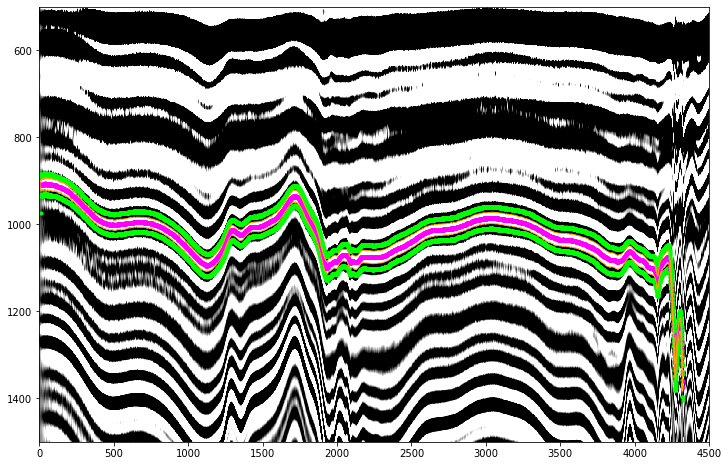

In [21]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

#plot contour
plt.plot(long_contours_subset[z][:, 1], long_contours_subset[z][:, 0], color='orange', linewidth=1)

#plot ridge and troughs
for i, x in enumerate(uniquex):
    y = ridge_points2[i]
    t = top[i]
    b = bottom[i]
    ax.scatter(x, y, color='magenta', marker='o', s=10)
    ax.scatter(x, t, color='lime', marker='o', s=10)
    ax.scatter(x, b, color='lime', marker='o', s=10)

ax.set_xlim(0, 4500)
ax.set_ylim(1500, 500)

plt.show()

#### Missing `find_contours()` method, for finding the actual contours

Eventually, this &#9660;&#9660;&#9660;&#9660; will need to be be its own method.

In [16]:
#save lists
argx_list = []
uniquex_list = []
saved_points_list = []

ridge_points_list = []
top, bottom = [], []
top_list, bottom_list = [], []

In [17]:
print(len(long_contours_subset))

78


### A check:
If the length of uniquex_list, saved_points_list, and ridge_points_list is not the same for a given point i, get rid of it.

In [18]:
for i, contour in enumerate(long_contours_subset):
    #get shape of data
    maxrows, maxcols = np.shape(data)
    
    #find x values for contour and where along that contour that x value occurs (aka, y values)
    uniquex, saved_points = find_contour_points(contour, argx_list)
    uniquex_list.append(uniquex)
    saved_points_list.append(saved_points)
        
    #find y values and ridge points for each contour
    ridge_points = []
    ridge = find_ridge_points(contour, uniquex, saved_points, data, ridge_points)
    ridge_points_list.append(ridge)
    
    #find top and bottom troughs/peaks
    top, bottom = find_troughs(uniquex, ridge, data)
    top_list.append(top)
    bottom_list.append(bottom)
    
    print(i, argx_list[i], len(uniquex_list[i]), len(saved_points_list[i]), len(ridge_points_list[i]))

0 [1454, 0] 666 666 666
1 [6054, 12090] 4320 4320 4320
2 [31, 232] 108 108 108
3 [380, 2564] 721 721 721
4 [181, 369] 106 106 106
5 [5970, 11722] 4135 4135 4135
6 [968, 2134] 559 559 559
7 [3, 1259] 646 646 646
8 [403, 171] 53 53 53
9 [6773, 14001] 4246 4246 4246
10 [59, 1360] 662 662 662
11 [4018, 6631] 1927 1927 1927
12 [6751, 13543] 4257 4257 4257
13 [268, 746] 311 311 311
14 [96, 808] 517 517 517
15 [666, 1326] 278 278 278
16 [53, 1346] 665 665 665
17 [6541, 13093] 4262 4262 4262
18 [164, 329] 99 99 99
19 [1223, 3273] 1389 1389 1389
20 [623, 1229] 258 258 258
21 [52, 186] 90 90 90
22 [327, 1557] 650 650 650
23 [4002, 8009] 2467 2467 2467
24 [0, 6714] 4269 4269 4269
25 [326, 1563] 642 642 642
26 [72, 380] 54 54 54
27 [7357, 14178] 4265 4265 4265
28 [308, 1579] 638 638 638
29 [50, 306] 49 49 49
30 [584, 1963] 630 630 630
31 [9104, 16066] 4122 4122 4122
32 [33, 293] 47 47 47
33 [1779, 5919] 1573 1573 1573
34 [41, 171] 15 15 15
35 [10, 235] 37 37 37
36 [356, 1888] 631 631 631
37 [10149

I need to make this it's own method, maybe. There is a `plot_picks()` method in ImpDAR, though, so maybe not. The determining factor will be whether or not I can convect the t, r, b arrays for each contour into a pick.

````python
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

#plot grid
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for i, contour in enumerate(long_contours_subset):
    #plot contours
    ax.plot(contour[:, 1], contour[:, 0], color='orange', linewidth=1)

    #plot ridge points
    ridge = ridge_points_list[i]
    uniqx = uniquex_list[i]
    top_ = top_list[i]
    bottom_ = bottom_list[i]
    
    for j, x in enumerate(uniqx):
        t = top_[j]
        r = ridge[j]
        b = bottom_[j]
        
        ax.scatter(x, t, color='lime', marker='o', s=10)
        ax.scatter(x, r, color='magenta', marker='o', s=10)
        ax.scatter(x, b, color='lime', marker='o', s=10)
        
    print('Done processing contour {}/{}'.format(i+1, len(long_contours_subset)))
    

ax.set_ylim(3000, 500)

plt.savefig('internal_reflectors1.pdf', format='pdf', bbox_inches='tight')
#plt.show()
````

This method is too time-consuming. Moving over to a trimmed-down Python command line version for output.

In [25]:
power = []

for i in range(len(ridge_points_list)):
    t_ = np.array(top_list[i])
    r_ = np.array(ridge_points_list[i])
    b_ = np.array(bottom_list[i])
    
    pick_power = np.mean(np.sum(t_**2 + r_**2 + b_**2))
    power.append(pick_power)

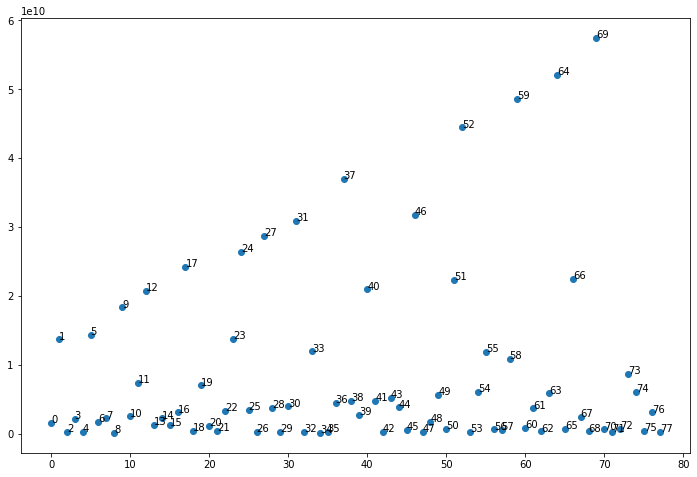

In [26]:
powerx = list(range(len(power)))

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(powerx, power)

for i, label in enumerate(powerx):
    ax.annotate(label, (powerx[i], power[i]))

plt.show()

I wonder if we could separate the contours based on their power content. Bed picks have super low averaged power, then a layer above, and again for the contours above those.

The above method alone will not work. I might be able to cluster them somehow, but other than that I need to separate them.

In [ ]:
#try and define bubble sort here
#will need to keep track of original index so that we can also change the positions of top_list and bottom_list list items
"""
Pass in the list containing all of the ridges that you found from the find_ridge() method.
This method is going to sort that list by x and y coordinates, performing a kind of nested bubble sort.
The goal of this method is to arrange contours such that:
- contours with first (x, y) pairs closest to the upper left corner of the radargram will come first
- contours with first (x, y) pairs closest to the lower right will come last.

Returns a list of ridge lines sorted by first (x, y) pair.
"""
def bubble_sort(ridge_list):
    
    pass